
############################################################################

This a shared directory. Please add a shortcut to you MyDrive folder to make it work. Make sure it is the whole folder !!!

############################################################################


In [1]:
!pip install tensorflow_io
!pip install tensorflow_addons

     |████████████████████████████████| 23.4 MB 6.4 MB/s 
     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)      
cwd = f'{ROOT}/MyDrive/autoencoder'

/content/drive
Mounted at /content/drive


In [2]:
'''
This file uses the experimental tool published by tensorflow to load
tiff files

I expect the subset ot look like:
foldername:
        label1:
            img1
            img2
            img3 
            ...
        ...

I produce a list of all images in all files without labels:
[ tensor(img1), tensor(img2), ...]

'''

import pandas as pd
import tensorflow as tf
import numpy as np
import json
import tensorflow_io as tfio
import os
#import tf.image.ResizeMethod as ResizeMethod


class process_tiff_img_set():
    def __init__(self, ds_folder_name):
        
        self.folder = ds_folder_name
        self.df =  self.create_df()

    def pad_img(self, img):
      
      image_stack = img
        
      img_shape = tf.shape(image_stack)
      
      extra_top = int((8000-img_shape[0]))
      extra_bottom = 0

      
      extra_right = int((2000-img_shape[1]))
      extra_left = 0
      padded = np.pad(image_stack, ((extra_top, extra_bottom), (extra_left, extra_right), (0, 0)), mode='constant', constant_values=0) 
      return padded

    def decode_img(self, img):
        #print(f'decoding ... ')
        img = tfio.experimental.image.decode_tiff(img, index=0, name=None)[:, :, :3]
        #img_np = np.pad(img, (256, 256, 3))
        #tensor_img = tf.convert_to_tensor(a)   
        #print(tf.size(img))
        #print(tf.shape(img))
        # resize the image to the desired size
        img = self.pad_img(img)
        return img
        '''tf.image.resize_with_pad(
                img,
                256,
                256,
                method=tf.image.ResizeMethod.BILINEAR,
                antialias=False
            )'''


    def process_path(self, file_path):

        # load the raw data from the file as a string
        #print(f'reading {file_path}')
        img = tf.io.read_file(file_path)
        img = self.decode_img(img)

        return img

    def create_df(self):
        '''
        This function creates a dataframe with all labels and 
        images file paths
        I will use later to store numpy arrays
        '''
        cwd = f'/content/drive/MyDrive/autoencoder'
        ds = []
        DS_PATH = os.path.join(cwd, self.folder)
        labels = os.listdir(DS_PATH)
        for lbl in labels:
            cwd = os.path.join(DS_PATH, lbl)
            if(not os.path.isdir(cwd)):
                print(f'{cwd} is not a directory. Will not be in dict')
                continue
            images = os.listdir(cwd)
            for img in images:
                #convert to numpy matrix here
                if(img.split('.')[1] != 'tif'):
                    print(f'{img} is not a tiff file. Will not be in dict')
                    continue
                path = os.path.join(cwd, img)

                #changes
                img_np = self.process_path(path) #Tensor 
                ds.append(img_np)

        
        return ds
  
    def get_tensor(self):
        return (self.df)


    def __str__(self):
        obj_str = ""
        for i, obj in enumerate(self.df):
            obj_str += f'{i}: {str(obj)},\n'
        return f'<process_tiff_img_set>:\n{obj_str}'





In [4]:
'''
I found this model in Kaggle
It uses VGG16 model like I found in the paper
I attached a single Dense layer with a Relu activation just to output the alpha
value
'''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from keras.models import Model


IMAGE_SIZE = [256, 256]

vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False) 

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False


x = Flatten()(vgg.output)
#x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
x = Dense(1, activation = 'relu')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

vgg16 = Model(inputs = vgg.input, outputs = x)

vgg16.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

      

58900480/58889256 [==============================] - 1s 0us/step


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os

from tensorflow.keras import layers
from tensorflow.keras.losses import *
from keras.models import Model
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      #layers.Flatten(),
      layers.Dense(latent_dim, activation='sigmoid'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(4, activation='sigmoid'),
      #layers.Reshape((256))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    
    decoded = self.decoder(encoded)
    return decoded

In [4]:
x_train = process_tiff_img_set("subset1")
x_train = x_train.get_tensor()


x_test = process_tiff_img_set('subset2')
x_test = x_test.get_tensor()

/content/drive/MyDrive/autoencoder/subset1/.DS_Store is not a directory. Will not be in dict


In [8]:
import os
import pandas as pd

#x_train & x_test are a list of tensors
#each tensor is 256x256, dtype=float32
#
#print to get more insight
#print(f'x_train: {x_train}')
#print(f'x_test: {x_test}')




autoencoder = Autoencoder(64)
autoencoder.compile(optimizer='rmsprop', loss=tf.keras.losses.BinaryCrossentropy)

history = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size = 2,
                shuffle=True,
                
                verbose=1)


Epoch 1/10


ValueError: ignored

KeyError: ignored

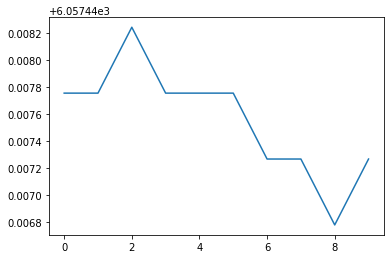

In [ ]:
import matplotlib.pyplot as plt


# Plot history: MAE
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('AutoEncoder loss function')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
#save model
autoencoder.save(f'{ROOT}/MyDrive/autoencoder/saved_models/autoencoder_Dense_only')

In [ ]:
!path=drive/MyDrive/"Github Repos"/